# Introduction to Clustering with Customer Segmentation

What is clustering? Clustering is an unsupervised machine learning algorithm that only takes input, X, but not labelled output, y. Clustering algorithms partition datas into distinct subgroups/clusters. For example, given a dataset of mall customers with features like 'Age', 'Income', 'Spending Score', we feed the clustering algorithm with the dataset and it will create a number of clusters based on the characteristics of the data and the specific algorithm with its parameters we use for clustering. In clustering, our main goal is to break down a big dataset into a few distinct subgroups so that we can use the subgroups to understand our data more easily or in a technical term, exploratory data analysis. However, since we do not have any labelled data for clustering algorithm, it is often diffucult to measure the performance of our model since we cannot compare the clusters with some ground truth answer to measure the performance. So, domain knowledge of the dataset is very important to interpret if we have reasonable and useful clusters.

There are many clustering algorithms and we will discuss three of the most popular ones which are:
 - K-Means clustering
 - Hierachical clustering(Agglomerative approach)
 - DBSCAN(Density Based Spatial Clustering of Application with Noise) 

Goals of this notebook:
 - Provide intuitive tutorial of clustering technique
 - Applying clustering techniques and evaluate their performance on certain dataset
 - Discuss the pros and cons of each of the three techniques

## Understanding the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import mglearn

df = pd.read_csv("mall_customers.csv")

#### 1. Looking at the first 5 rows of the data

In [2]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


#### 2. Renaming the columns so that it is easier to use later.

In [3]:
df.columns = ['customer_ID','gender','age','annual_income','spending_score']
df.head()

,customer_ID,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


#### 3. The data contains 200 rows and 5 columns.

In [4]:
df.shape

(200, 5)

#### 4. There is no duplicated rows.

In [5]:
df.duplicated().any()

False

#### 5. There is no missing values in the dataset. 

In [6]:
df.isnull().any()

customer_ID       False
gender            False
age               False
annual_income     False
spending_score    False
dtype: bool

#### 6. Changing the index of the dataset to 'customer_ID' since 'customer_ID' will not provide us any insightful information for that customer except for indexing the specific customer.

In [7]:
df = df.set_index(['customer_ID'])
df.head()

,gender,age,annual_income,spending_score
customer_ID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## Exploratory Data Analysis and Data Visualization

#### Inspect the relationship between each feature using a pairplot.

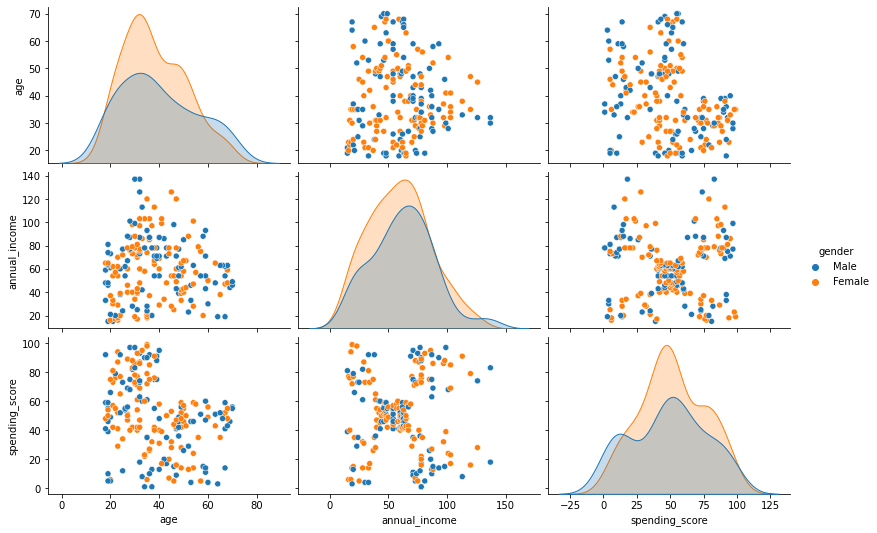

In [8]:
sns.pairplot(df, hue='gender',aspect = 1.5)
plt.show()

- From the plot above, we can see that there is no obvious difference between Male and Female in all plots.
- As a result, we will drop the 'gender' column since most of the distance-based algorithm cannot process categorical/binary data properly to provide meaningful results. To cluster a dataset with both numerical and categorical data, you can consider and look for K-Modes clustering which is out-of-scope of this discussion.

## Clustering

#### Dropping the 'gender' column for our three distance-based clustering techniques.

In [9]:
X = df.drop(['gender'], axis=1)
X.head()

,age,annual_income,spending_score
customer_ID,,,
1,19,15,39
2,21,15,81
3,20,16,6
4,23,16,77
5,31,17,40


### 1. K-Means Clustering

K-Means clustering is one of the most simple and commonly used clustering algorithm. It works as follows:
 1. Randomly assign k = n_clusters of cluster centre(centroids).
 2. Assign each datapoint to the closest centroids.
 3. Calculate the mean of all the points in each cluster and reassign the centroid of each cluster as the mean.
 4. Reassign each datapoint to the closest centroid based on Euclidean distance.
 5. Repeat Step 3 and Step 4 until the total sum of the within-cluster variation over the three clusters is the minimum.

#### An illustration showing the steps of K-Means clustering, taken from 'Introduction to Machine Learning with Python' book.

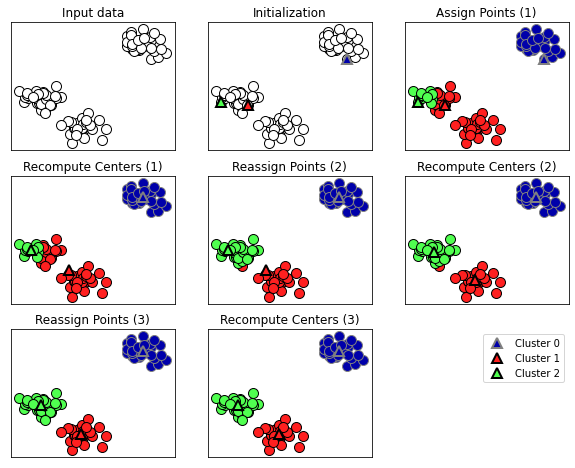

In [10]:
mglearn.plots.plot_kmeans_algorithm()

#### Implementation for Customer Data

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
clusters = []
ss = []

#Calculate all the sum of within-cluster variance for n_clusters from 2 to 14

for i in range(2,15):
    km = KMeans(n_clusters = i)
    km.fit(X)
    clusters.append(km.inertia_)
    ss.append(silhouette_score(X, km.labels_, metric='euclidean'))


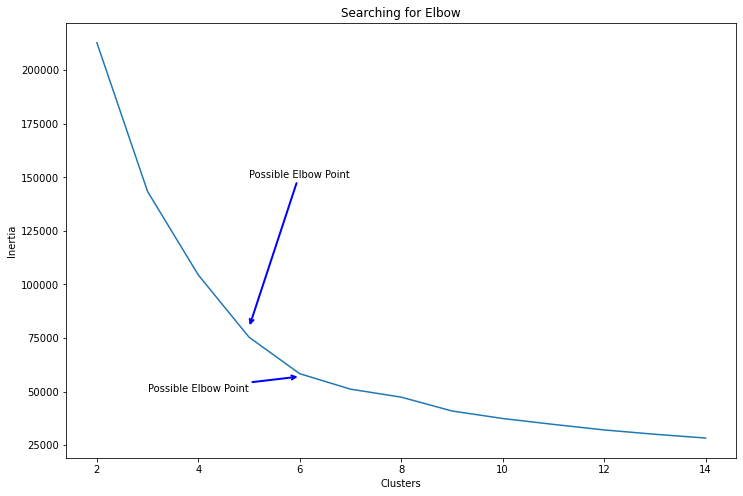

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(2, 15)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

# Annotate arrow
ax.annotate('Possible Elbow Point', xy=(6, 57000), xytext=(3, 50000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

ax.annotate('Possible Elbow Point', xy=(5, 80000), xytext=(5, 150000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

plt.show()

- __The plot above is called an elbow method/plot. It illustrates the inertia(sum of squared distances of each data point to their closest centroid / sum of within-cluster variance) against n_clusters(number of clusters). Practically, we will not choose the n_clusters for the minimum inertia and instead, we will choose the so-called elbow point, as illustrated above, since it explains the majority of the inertia(variance). However, sometimes by just visually inspecting the elbow points are not enough to tell which n_clusters is the optimal choice like the elbow plot illustrated above. One way to tackle this problem is to pick both elbow points, use them for clustering, evaluate the results based on our domain knowledge and finally choose the best n_clusters. Increasing the number of clusters from that elbow point does not provide extra much information and it might produce an undesired results. As a rule of thumb, we choose the n_clusters based on the elbow point.__

- __Another way is to use another metric, Silhouette score, to validate our choice of n_clusters.The Silhouette score measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). The range of Silhouette score is between -1 and +1. The score closer to +1 indicates that the data points are in the right cluster. If many points have negative Silhouette score, it may indicate that we either have created too many clusters or too less clusters. Silhouette score also utilize Euclidean distance to compute its score. In contrast to inertia, Silhouette score reaches its global maximum at the optimal K value.__ 

Text(0, 0.5, 'Silhouette Score')

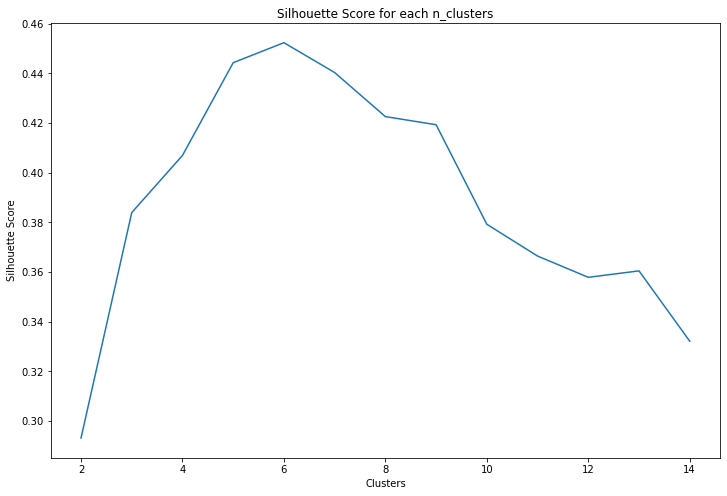

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(2, 15)), y=ss, ax=ax)
ax.set_title('Silhouette Score for each n_clusters')
ax.set_xlabel('Clusters')
ax.set_ylabel('Silhouette Score')

- __As we can see from the plot above, K=6 is has a higher Silhouette score than K=5 but both are very close, hence, we can inspect both possibilities and finally choose the one which is more sensible gauged by our domain knowledge.__
- __The Elbow method is more like a decision rule rather than a metric while the Silhouette score is a metric for clustering validation. Hence, they are not alternative to each other to find optimal K but rather, they can be used together to find a value of K with more confident.__

/Users/oscarliu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


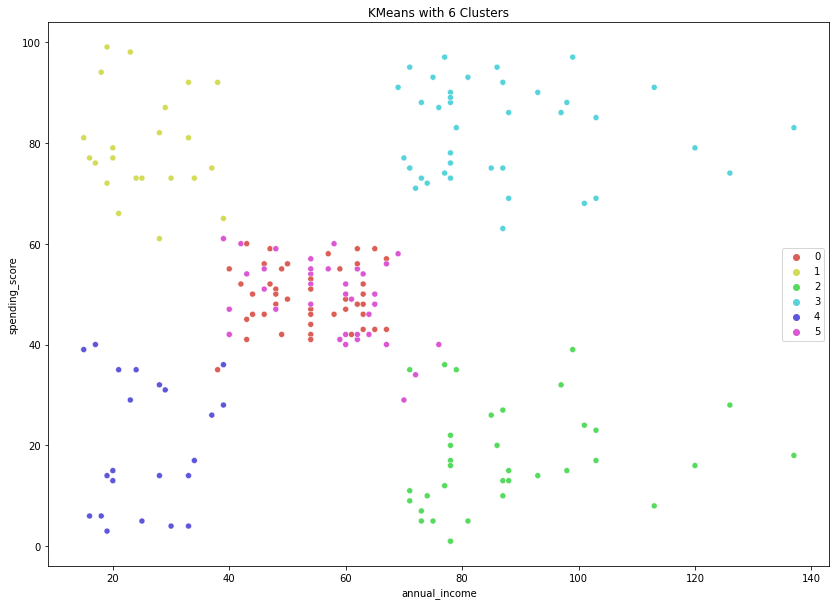

In [14]:
km6 = KMeans(n_clusters=6).fit(X)

X['Labels'] = km6.labels_
plt.figure(figsize=(14, 10))
sns.scatterplot(X['annual_income'], X['spending_score'], hue=X['Labels'], 
                palette=sns.color_palette('hls', 6))
plt.title('KMeans with 6 Clusters')
plt.legend(loc='center right')
plt.show()

- __As we can see from the scatterplot above, there are 4 obvious clusters and two mixed clusters in the middle(green+red)__

/Users/oscarliu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


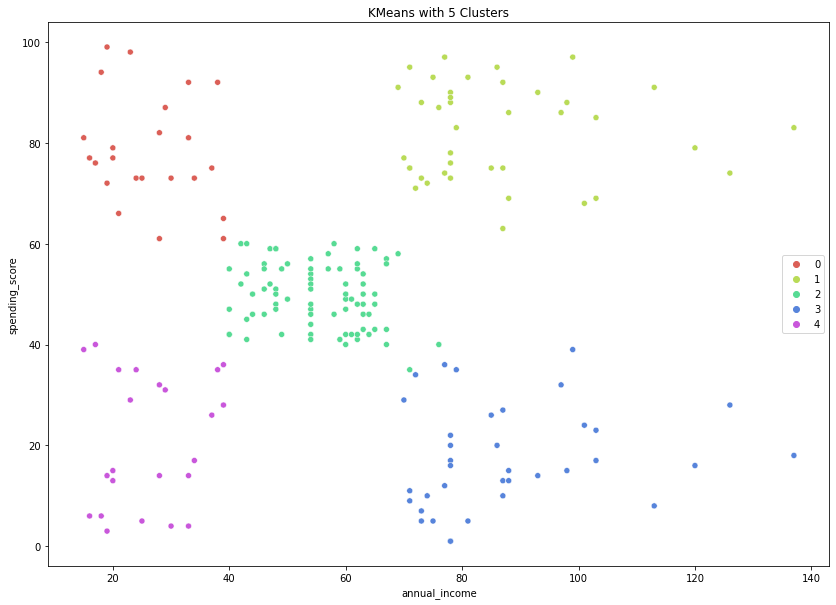

In [15]:
km5 = KMeans(n_clusters=5).fit(X)

X['Labels'] = km5.labels_
plt.figure(figsize=(14, 10))
sns.scatterplot(X['annual_income'], X['spending_score'], hue=X['Labels'], 
                palette=sns.color_palette('hls', 5))
plt.title('KMeans with 5 Clusters')
plt.legend(loc='center right')
plt.show()

- __As compare to the 6 clusters plot, 5 clusters can better differentiate each of the subgroups. The five groups are:__
 1. Low income with low spending score(Cluster 1)
 2. Low income with high spending score(Cluster 2)
 3. Medium income with medium spending score(Cluster 0)
 4. High income with low spending score(Cluster 4)
 5. High income with high spending score(Cluster 3)
 

- __For the 6 clusters plot, there are two clusters in the middle income with medium spending score which we cannot tell the differences between the two clusters in the middle. Hence, with our domain knowledge, we choose K = 5 which is better representing our data.__

- __We can also conclude that K-Means is very good at customer segmentation, more specifically on data clusters that have a spherical distribution. This is because K-Means utilize a centroid and the centroid measure each data point's distance from the centroid to the point using Euclidean distance in all direction from the centroid.__

- __As a result, K-Means tend to perform very badly when the data clusters do not have spherical shape.__

#### Clustering of half-moon-shaped dataset with KMeans

Text(0, 0.5, 'Feature 1')

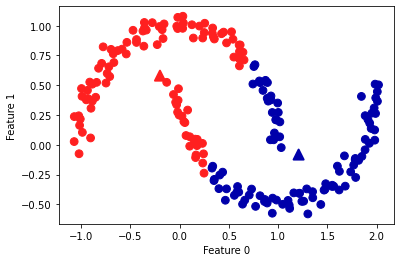

In [16]:
from sklearn.datasets import make_moons
x, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# cluster the data into two clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(x)
y_pred = kmeans.predict(x)
  

plt.scatter(x[:, 0], x[:, 1], c=y_pred, cmap=mglearn.cm2, s=60)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                marker='^', c=[mglearn.cm2(0), mglearn.cm2(1)], s=100, linewidth=2)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

- __We can clearly see KMeans fail to cluster correctly the above two half-moon shaped datas because their distribution of data is not spherical. We can see that the model cluster all the datapoint that is within a certain distance from the centroid(blue and red triangle) as the same cluster. So, we should inspect our data and consider properly when we choose our clustering algorithm.__

### 2. Hierachical clustering(Agglomerative approach)

Agglomerative hierachical clustering is a suite of clustering algorithms which build upon the same principles(bottom-up): the algorithms first declaring all the data points as clusters of its own and then the two most similar clusters will merge together and so on until a stopping criterion is achieved. For scikit-learn, the stopping criterion is the number of clusters(n_clusters). The algorithm also takes a 'linkage' parameter which tells us 'how to identify two most similar clusters'. There are four types of linkage implemented by scikit-learn:
 1. ward: minimize the variance of the clusters being merged.
 2. average: uses the average distance of each observation of the two sets
 3. complete/maximum: uses the maximum distance between all the observations of the two sets
 4. single: uses the minimum distance between all the observations of the two sets
ward works on most datasets and it is the default option for scikit-learn, if the clusters have very dissimilar number of members(if one is much bigger than all the others) , average or complete might work better.

The metric(a.k.a dissimilarity measure) to compute the linkage can be chosen as well, the most common ones are:
1. Euclidean distance(default)
2. Manhattan distance
3. Correlation-based distance(Focus on shape of observations rather than magnitudes)
Choices of linkage and its metric affect the result produce by the algorithm, so we should consider the type of data being examined and the scientific question at hand before picking a certain combination of linkage and metric.
In practice, we should try all possibly insightful and useful combinations and then determine which one matches our desired outcome/ provide us the most insight from the data.

The algorithm work as follows:
1. Assign each point as a cluster of their own
2. Two clusters that are closest to each other, if we uses Euclidean distance as dissimilarity metric and average as linkage.For example, a cluster will compare itself to all the other clusters by finding the Euclidean distance between the cluster centroid(average of a cluster) and all other clusters centroids. 
3. After that, the cluster will merge with the other cluster that have the shortest(minimal) Euclidean distance from its centroid. This is how the algorithm recognize 'how similar two clusters are'(i.e. shortest Euclidean distance between cluster centroids for 'average' linkage case).
4. Step 2-4 are repeated until the stopping criterion(i.e. the number of clusters determined) is satisfied.

After the agglomerative hierachical clustering, we will always use a dendrogram to visually inspect our result. We will look into the details dendrogram later.

#### An example of the agglomerative clustering operations with 3 clusters (plot taken from 'Introduction to Machine Learning in Python' book)

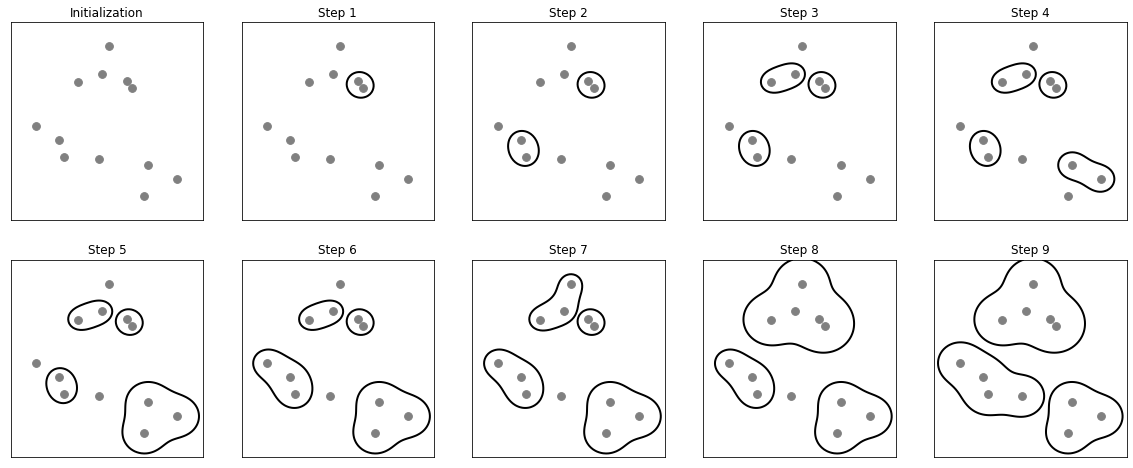

In [17]:
mglearn.plots.plot_agglomerative_algorithm()

- __First, all the points are initialized as individual clusters. Then, in each step, the two closest clusters are merged together. In the first four steps, 4 set of two points clusters are formed. In step 5 - 7, three 3-point clusters are formed and then finally in step 9, 3 main clusters are formed.__

#### Clustering for customer data

/Users/oscarliu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


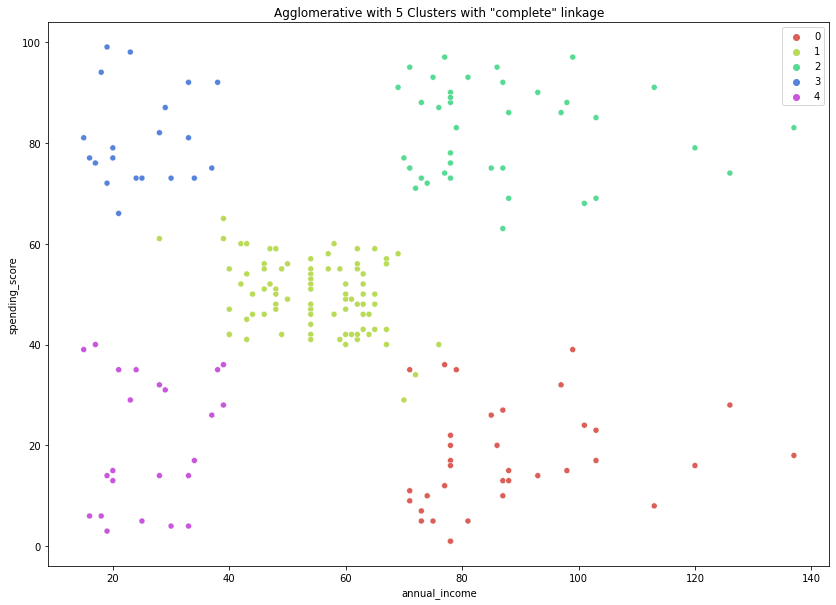

In [18]:
from sklearn.cluster import AgglomerativeClustering 

aggloclus = AgglomerativeClustering(n_clusters=5, linkage='complete').fit(X)

labels = aggloclus.labels_
plt.figure(figsize=(14, 10))
sns.scatterplot(X['annual_income'], X['spending_score'], hue=labels, 
                palette=sns.color_palette('hls', 5))
plt.title('Agglomerative with 5 Clusters with "complete" linkage')
plt.show()

- __From the scatterplot above, we can see that agglomerative clustering work as well as KMeans clustering in customer segmentation, the five distinct clusters are similar to the five clusters produced by KMeans clustering. In this plot, we used 'complete' linkage and 5 clusters.__

/Users/oscarliu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


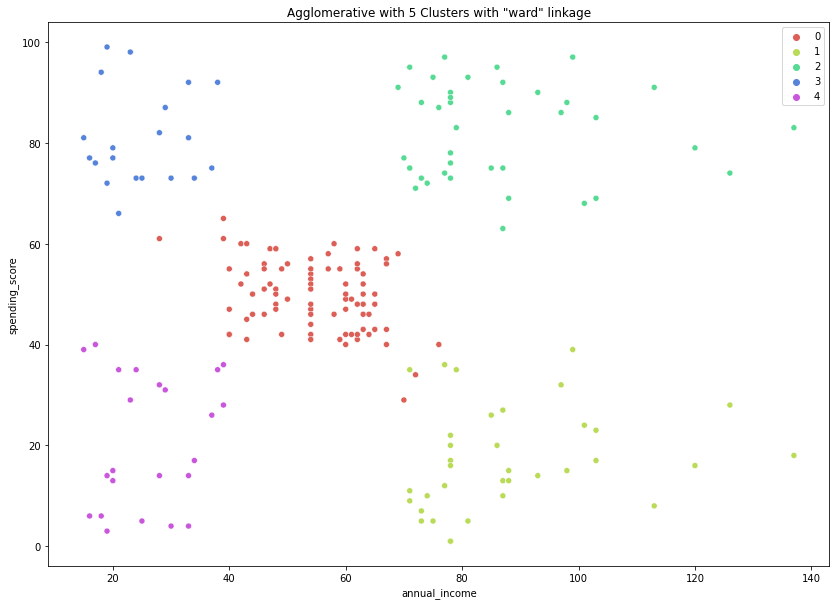

In [19]:
from sklearn.cluster import AgglomerativeClustering 

aggloclus = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(X)

labels = aggloclus.labels_
plt.figure(figsize=(14, 10))
sns.scatterplot(X['annual_income'], X['spending_score'], hue=labels, 
                palette=sns.color_palette('hls', 5))
plt.title('Agglomerative with 5 Clusters with "ward" linkage')
plt.show()

- __We can see that the clusters are identical to the one using 'complete' linkage. This might indicate that the clusters are well-defined since changing the linkage does not affect the clusters. This plot uses 'ward' linkage and 5 clusters.__

#### Dendrogram

In [42]:
import plotly.figure_factory as ff
import plotly.graph_objects as go
from scipy.cluster.hierarchy import ward
linkage = ward(X)
fig = ff.create_dendrogram(linkage, color_threshold = 260)
fig.update_layout(width = 1000, height = 600, yaxis_title = 'Cluster distance', xaxis_title = 'Sample index')
fig.update_xaxes(showticklabels=False)
fig.add_shape(
        type='line',
        x0=0,
        y0=260,
        x1=1985,
        y1=260,
        line=dict(
            color='Black',
            dash='dash'
        )
)
fig.show()

- __The dendrogram is a tree-like diagram where the top is the root and the bottom part is the leaves. The leaves are made up of individual data points and a new node parent is added for each two clusters that are merged.__

- __The vertical axis(cluster distance) depicts the Euclidean distance(in this case). As we move up from the bottom, the leaves merge into branches and this corresponds to the samples/clusters that are similar to each other. The vertical distance represents how similar the clusters are, so for example, the greater the vertical distances before the merge happen, the more dissimilar the clusters are. This can be seen at the merge of the root(the top part), where the left main branch and the right main branch merge together, the vertical distance is as much as 300, which means they are very dissimilar compare to a vertical distance, say 5, which represents very similar clusters.__

- __The dashed line show where we choose to cut the dendrogram to get a desired number of clusters. The number of vertical lines before branching under the dashed lines tells us the number of clusters we will have if we cut at the vertical distance(cluster distance). In this dendrogram, we can see there are five clusters when we cut at cluster distance = 260, there is a very tiny(unable to see) vertical line at the rightmost part of the graph(the yellow clusters) before it branches, so there are 5 vertical lines under the dashed lines instead of 6 before branching.__ 

- __So, using this dendrogram, we can look at each individual clusters and how they merge together to form into a larger cluster from bottom up. This provides us a lot of information since we can inspect each individual samples and examine how similar(or dissimilar) are they with the samples they merge with. Also, we can use this to choose how many clusters we would like to have by cutting at different cluster distances.__
- __In practice, people often look at the dendrogram and select by eye a sensible number of clusters, based on the heights of the merge and the numbers of clusters desired.__

#### Clustering of half-moon-shaped dataset with Agglomerative Clustering

Text(0, 0.5, 'Feature 1')

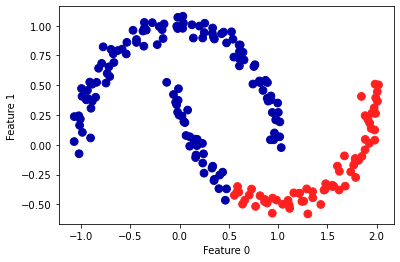

In [52]:
from sklearn.datasets import make_moons
x, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# cluster the data into two clusters
agglo =  AgglomerativeClustering(n_clusters=2, linkage='average')
y_pred = agglo.fit_predict(x)

  

plt.scatter(x[:, 0], x[:, 1], c=y_pred, cmap=mglearn.cm2, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

- __As we can see from the plot above, agglomerative clustering does not deal well with the half-moon-shaped data when we use 'average' linkage.__


Text(0, 0.5, 'Feature 1')

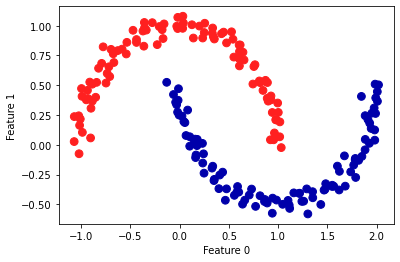

In [53]:
agglo =  AgglomerativeClustering(n_clusters=2, linkage='single')
y_pred = agglo.fit_predict(x)

  

plt.scatter(x[:, 0], x[:, 1], c=y_pred, cmap=mglearn.cm2, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

 - __However, we can correctly clusters the half-moon-shaped data when we use 'single' linkage. This is because 'single' use the minimum distance to identify similar clusters and the gap between the two real clusters are big.__

### 3. DBSCAN(Density Based Spatial Clustering of Application with Noise)